<a href="https://colab.research.google.com/github/TEhyeok/AIFFEL_Exploration/blob/main/News_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
data = pd.read_csv("/content/drive/MyDrive/aiffel/Review/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [44]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [45]:
data = data[['Summary', 'Text']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Summary,Text
83794,Ground too fine,We'd been buying the four-pack of Melitta Fren...
48334,tasteless,consistency is ok but product is absolutely ta...
58202,Best brand out there,Our son is now 11 months old and we've been us...
51828,great tea,I love this tea company they make great stuff....
95841,"No shortage of potatoes in this mild, comforti...",I think this is one of the better gluten-free ...
71956,"Very tasty and healthy, but could be more in box","I really enjoy this cereal, appreciate its hea..."
90529,Package was not sealed. Popcorn not fresh.,When my husband brought in the delivered packa...
50793,What is in this?,I used this once. It works. My hair is strong...
25594,"Four cats, a large jar of cat-nip. Go figure.",I have one cat that even though the cat-nip ma...
22039,too scary for my dog,"I was all excited to find a toy that my smart,..."


In [46]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [47]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [48]:
print(data.isnull().sum())

Summary    1
Text       0
dtype: int64


In [49]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


In [50]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [51]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있죠. 이를 사용하여 불용어를 제거할 거예요. 이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요.

In [52]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [53]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [54]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

for index, item in data.iterrows():
    text = preprocess_sentence(item['Text'])

    clean_text.append(text)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

<ipython-input-52-8985a2a10398>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [55]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_summary = []

for index, item in data.iterrows():
    summary = preprocess_sentence(item['Summary'], False)

    clean_summary.append(summary)

print("Summary 전처리 후 결과: ", clean_summary[:5])

<ipython-input-52-8985a2a10398>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
<ipython-input-52-8985a2a10398>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋아요. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있어요. 이렇게 되면 샘플 자체가 빈 값을 가지게 되겠죠.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장할게요. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체해요.

In [56]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [57]:
data.isnull().sum()

Summary    70
Text        0
dtype: int64

In [58]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례에요.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


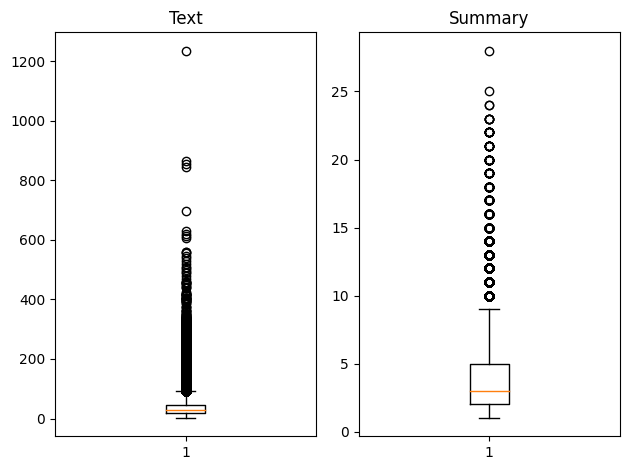

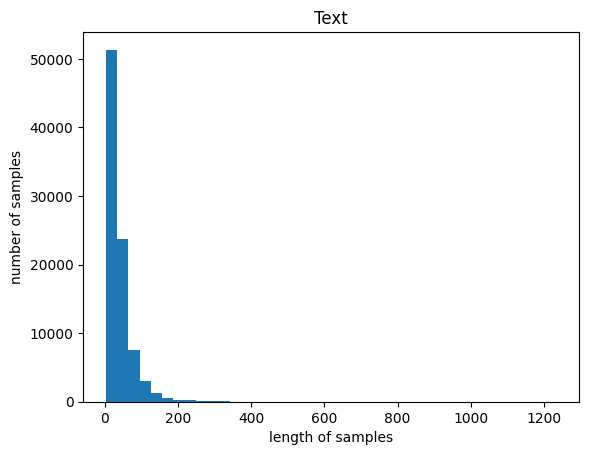

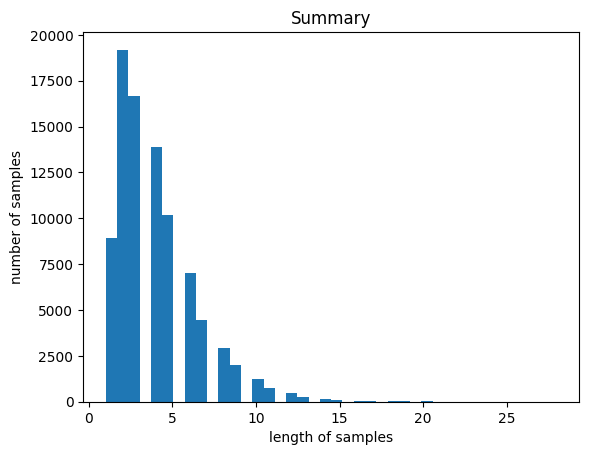

In [59]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 돼요. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있어요.

Text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 크죠. 하지만 평균 길이는 38로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있어요.

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.

In [60]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [61]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [62]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [63]:
# 길이 조건을 만족하는 샘플만 필터링
filtered_data = data.apply(lambda x: len(x['Text'].split()) <= text_max_len and len(x['Summary'].split()) <= summary_max_len, axis=1)
data = data[filtered_data]

# 결과 확인
print('전체 샘플수 :', len(data))


전체 샘플수 : 65818


In [64]:
text = "hello world"
words = text.split()  # 기본 구분자는 공백
print(words)

['hello', 'world']


In [65]:
text_example = "bough t"

text_len = [len(s.split()) for s in text_example]

print(text_example)
print(text_len)
print(len(text_len))

bough t
[1, 1, 1, 1, 1, 0, 1]
7


앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억하시나요? 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 Summary 열로부터 만들 거예요.

In [66]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-66-2597ec9a2495>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
<ipython-input-66-2597ec9a2495>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')


,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,sostoken good quality dog food,good quality dog food eostoken
1,not as advertised,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised,not as advertised eostoken
2,delight says it all,confection around centuries light pillowy citr...,sostoken delight says it all,delight says it all eostoken
3,cough medicine,looking secret ingredient robitussin believe f...,sostoken cough medicine,cough medicine eostoken
4,great taffy,great taffy great price wide assortment yummy ...,sostoken great taffy,great taffy eostoken


앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.

In [67]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


이제 훈련 데이터와 테스트 데이터를 분리할거에요.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해볼게요. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [68]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 4175 46155 17665 ... 62266 35306 48504]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [69]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [70]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해 주세요.

In [71]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


훈련 데이터와 테스트 데이터가 각각 52,655개와 13,163개로 잘 분리된 것을 볼 수 있어요!

---
## 3-7. 데이터 전처리하기 (3) 정수 인코딩

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [72]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요.

In [73]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32034
등장 빈도가 6번 이하인 희귀 단어의 수: 23818
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8216
단어 집합에서 희귀 단어의 비율: 74.35225073359555
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4090139149534933


encoder_input_train에는 3만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해볼까요?

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않아요.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [74]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [75]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[71, 506, 1085, 477, 2715, 89, 7, 1378, 40, 3, 122, 51, 1455, 3399, 1113, 2564, 387, 3971, 432, 3023, 1925, 2235, 506, 21, 3023, 948, 1706, 1331, 3971, 214, 772, 1641, 724, 128], [227, 357, 164, 11, 45, 12, 28, 73, 143, 1744, 9, 85, 227, 2387], [165, 10, 558, 41, 213, 564, 120, 33, 141, 564, 52, 7, 15, 1265, 1801, 71, 134, 847, 3, 1265, 6146, 85, 207, 2716, 12, 314, 26, 949]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있어요.

Summary 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.

In [76]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [77]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10582
등장 빈도가 5번 이하인 희귀 단어의 수: 8202
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2380
단어 집합에서 희귀 단어의 비율: 77.50897750897751
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.93576832161479


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요. 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요.

In [78]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3, 20], [1, 293, 74], [1], [1, 9, 5, 77, 114, 728, 5, 182], [1, 9, 15, 99]]
target
decoder  [[3, 20, 2], [293, 74, 2], [2], [9, 5, 77, 114, 728, 5, 182, 2], [9, 15, 99, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [79]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1290
삭제할 테스트 데이터의 개수 : 319
훈련 데이터의 개수 : 51365
훈련 레이블의 개수 : 51365
테스트 데이터의 개수 : 12844
테스트 레이블의 개수 : 12844


### 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [80]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


## 3-8. 모델 설계하기
이제는 모델을 설계할 시간이에요. 우선 함수형 API를 이용해서 인코더를 설계해 볼게요.

In [81]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했어요. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니에요.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있어요. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이에요.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요. 즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.

아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것입니다. 색이 있는 화살표는 dropout을 나타낸 것이에요. (색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가셔도 됩니다.) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있습니다. 그렇게 되면 오른쪽 그림과 같은 형태가 되겠군요. 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 해요.

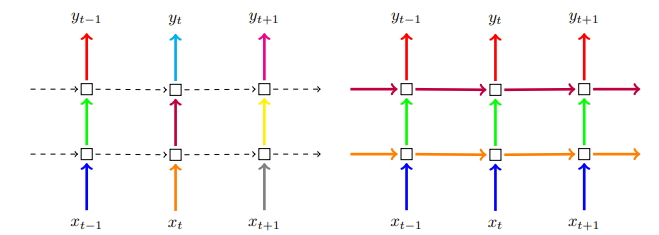

In [82]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [83]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 50, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [84]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 50, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [85]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 37s 108ms/step - loss: 2.8970 - val_loss: 2.5569
Epoch 2/50
201/201 [==============================] - 11s 54ms/step - loss: 2.5498 - val_loss: 2.4824
Epoch 3/50
201/201 [==============================] - 10s 49ms/step - loss: 2.4653 - val_loss: 2.4188
Epoch 4/50
201/201 [==============================] - 9s 43ms/step - loss: 2.4027 - val_loss: 2.3696
Epoch 5/50
201/201 [==============================] - 9s 45ms/step - loss: 2.3626 - val_loss: 2.3383
Epoch 6/50
201/201 [==============================] - 8s 41ms/step - loss: 2.3253 - val_loss: 2.3016
Epoch 7/50
201/201 [==============================] - 8s 42ms/step - loss: 2.2912 - val_loss: 2.2809
Epoch 8/50
201/201 [==============================] - 8s 40ms/step - loss: 2.2591 - val_loss: 2.2545
Epoch 9/50
201/201 [==============================] - 9s 43ms/step - loss: 2.2248 - val_loss: 2.2140
Epoch 10/50
201/201 [==============================] - 8s 40ms/step - loss: 2.1898 - va

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 해요.

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있어요. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있겠네요.

EarlyStopping에 대한 자세한 내용은 아래 링크를 참고하세요! 자주 쓰이는 도구이니 자세히 알아두면 매우 도움이 될 거예요!!

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Q. Early Stopping을 사용할 경우 조심해야 하는 경우가 있는데, 어떤 경우일까요?

patience가 0이 아닌 경우에는 훈련이 종료되었을 때 성능이 최고인 상황이 아닐 수 있습니다. 예를들어 patience가 3인 경우, 15 epoch에서 loss가 감소하다가 16 epoch부터 loss가 증가한다면 18 epoch 때 모델을 저장하고 학습을 종료합니다. 그래서 학습 중에 모델을 저장하는 callback 함수를 같이 사용한다.

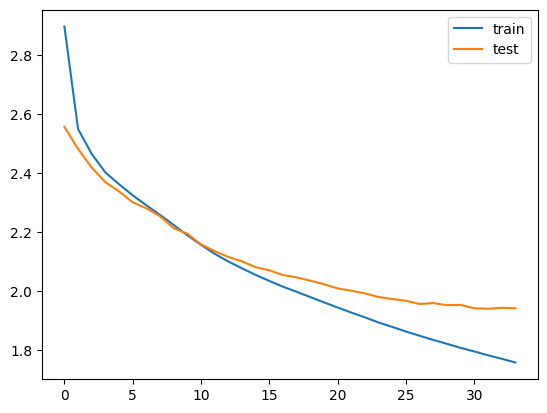

In [86]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

## 3-10. 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [87]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [88]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')


=3


어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [89]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [90]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


Q. 정답 문장이 없는 추론(inference) 단계에서는 왜 모델 설계를 별도로 해주어야 하나요?

생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문입니다.

## 3-11. 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

Q. seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
(힌트 : 요약문에는 sostoken과 eostoken을 고려해야 함)

In [92]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0) and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word[i] + ' '

print('=3')

=3


In [ ]:
# # 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
# def seq2text(input_seq):
#     temp=''
#     for i in input_seq:
#         if (i!=0):
#             # 사전에 없는 인덱스일 경우 대체 단어 사용
#             word = src_index_to_word.get(i, '[UNK]')
#             temp += word + ' '
#     return temp

# # 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
# def seq2summary(input_seq):
#     temp=''
#     for i in input_seq:
#         if (i!=0) and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
#             # 사전에 없는 인덱스일 경우 대체 단어 '[UNK]' 사용
#             word = tar_index_to_word.get(i, '[UNK]')
#             temp += word + ' '

# print('=3')

In [93]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : cannot get oil bottle cut top bottle another brand wide mouth jar know almost impossible container 
실제 요약 : None
1/1 [==============================] - 0s 21ms/step
예측 요약 :  great product


원문 : taste great bit pricey healthy snack options best artificial cardboard flavor added yr old son gfcf diet bars favorite snacks go give em try swear healthy 
실제 요약 : None
1/1 [==============================] - 0s 21ms/step
예측 요약 :  great snack


원문 : everyone cans severely dented dented sides carefully placed could see cans shrink wrapped packed plastic air bags damage box arrived dented packed 
실제 요약 : None
1/1 [==============================] - 0s 20ms/step
예측 요약 :  dented cans


원문 : bags lot stuff honestly one best snacks great occasion 
실제 요약 : None
1/1 [==============================] - 0s 22ms/step
예측 요약 :  great snack


원문 : tried lot sticks best tasted yes spicy hot spicy means purchased box little less promo great price amazon offers price definately pick two boxes 
실제 요약 : None
1/

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보이네요. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있어요. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과네요!

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 하네요. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재합니다. 이런 방안들에 대해서도 향후 살펴보게 될 것입니다.

## 3-12. 추출적 요약 해보기

앞서 seq2seq를 통해서 추상적 요약을 진행해봤어요. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었죠.

Q. 우리가 앞에서 seq2seq 모델을 사용하여 추상적 요약을 했습니다. 그렇다면 추출적 요약은 무엇일까요?

추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식입니다. 그래서 생성된 문장이나 단어는 원문에 포함되어 있기 때문에, 단점으로 언어 표현 능력이 제한되어 생성된 문장이 매끄럽지 않을 수 있습니다. 대표적인 알고리즘으로는 TextRank가 있습니다.

---
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀볼까요?

---
패키지 설치
클라우드의 경우 이미 summa 가 설치돼있습니다. 확인해보고 싶으시면 아래 명령어를 Cloud Shell에서 실행해보세요!

$ pip list | grep summa

In [97]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 719.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54388 sha256=15b2b33d9bc41cefc17b0defc8be74c6e724d5bf403041bd7c898a0dd13bbcc0
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [98]:
import requests
from summa.summarizer import summarize

In [99]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [100]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [101]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [102]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [103]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
